[CSCI 3370] Lab 5: Variational Autoencoders for Image Generation

Posted:

Due:



Submission: please rename the .ipynb file as your_username_lab5.ipynb before you submit it to canvas. Example: yuanyua_lab5.ipynb

---
# Assignment 5: Implementing a (Convolutional) Variational Autoencoder

In this assignment, you will implement a variational autoencoder (VAE) to generate human facial images based on the CelebA dataset.

In addition to the lecture slides, here's another good reference for this assignment: [Tutorial on Autoencoders (Carl Doersch, 2016)](https://arxiv.org/pdf/1606.05908)

As in the previous assignments, you will see code blocks that look like this:
```python
###############################################################################
# TODO: Create a variable x with value 3.7
###############################################################################
pass
# END OF YOUR CODE
```

You should replace the `pass` statement with your own code and leave the blocks intact, like this:
```python
###############################################################################
# TODO: Create a variable x with value 3.7
###############################################################################
x = 3.7
# END OF YOUR CODE
```

Also, please remember:
- Do not write or modify any code outside of code blocks
- Do not add or delete any cells from the notebook. You may add new cells to perform scatch work, but delete them before submitting.
- Run all cells before submitting. You will only get credit for code that has been run.


## Setup

First let's import some libraries that will be useful in this assignment.


In [1]:
!pip show torch torchvision sympy

Name: torch
Version: 2.5.1+cu121
Summary: Tensors and Dynamic neural networks in Python with strong GPU acceleration
Home-page: https://pytorch.org/
Author: PyTorch Team
Author-email: packages@pytorch.org
License: BSD-3-Clause
Location: /usr/local/lib/python3.10/dist-packages
Requires: filelock, fsspec, jinja2, networkx, sympy, typing-extensions
Required-by: accelerate, fastai, peft, sentence-transformers, timm, torchaudio, torchvision
---
Name: torchvision
Version: 0.20.1+cu121
Summary: image and video datasets and models for torch deep learning
Home-page: https://github.com/pytorch/vision
Author: PyTorch Core Team
Author-email: soumith@pytorch.org
License: BSD
Location: /usr/local/lib/python3.10/dist-packages
Requires: numpy, pillow, torch
Required-by: fastai, timm
---
Name: sympy
Version: 1.13.1
Summary: Computer algebra system (CAS) in Python
Home-page: https://sympy.org
Author: SymPy development team
Author-email: sympy@googlegroups.com
License: BSD
Location: /usr/local/lib/python

In [2]:
import zipfile
import datetime
import matplotlib.pyplot as plt
import random
import collections
import numpy as np
import zipfile
import os
import torch
import torch.utils.data
from torch import nn, optim
from torch.nn import functional as F
from torchvision import datasets, transforms
from torchvision.utils import save_image
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler

import gdown
from natsort import natsorted
from PIL import Image


def seed(seed):
  torch.manual_seed(seed)
  np.random.seed(seed)

GPU Check

In [3]:
if torch.cuda.is_available():
  print('Good to go!')
else:
  print('Please set GPU via Edit -> Notebook Settings.')
device = torch.device('cuda:0')

Good to go!


## Loading the Dataset

Fetch the CelebA (Liu et al. 2015) dataset from a google drive host

Check out the dataset and original publishing information here: https://mmlab.ie.cuhk.edu.hk/projects/CelebA.html

We are using a simple train/val split of $\sim$30k/$\sim$1k images from a subset of the CelebA dataset

In [4]:
# Fetch data from Google Drive
# Root directory for the dataset
data_root = 'data/celeba'
# Path to folder with the dataset
dataset_folder = f'{data_root}/celeba_lab5_dataset/'
# URL for the CelebA dataset
url = 'https://drive.google.com/uc?export=download&id=148kQ43LWLJtkdt6Mf3oVK2IoV54RGi-M'
# Path to download the dataset to
download_path = f'{data_root}/celeba_lab5_dataset.zip'

# Create required directories
if not os.path.exists(data_root):
  os.makedirs(data_root)
  os.makedirs(dataset_folder)

if not os.path.exists(download_path):
  # Download the dataset from google drive
  gdown.download(url, download_path, quiet=False)

# Unzip the downloaded file
with zipfile.ZipFile(download_path, 'r') as ziphandler:
  ziphandler.extractall(dataset_folder)

## Create a custom Dataset class
class CelebADataset(Dataset):
  def __init__(self, root_dir, transform=None):
    """
    Args:
      root_dir (string): Directory with all the images
      transform (callable, optional): transform to be applied to each image sample
    """
    # Read names of images in the root directory
    image_names = os.listdir(root_dir)

    self.root_dir = root_dir
    self.transform = transform
    self.image_names = natsorted(image_names)

  def __len__(self):
    return len(self.image_names)

  def __getitem__(self, idx):
    # Get the path to the image
    img_path = os.path.join(self.root_dir, self.image_names[idx])
    # Load image and convert it to RGB
    img = Image.open(img_path).convert('RGB')
    # Apply transformations to the image
    if self.transform:
      img = self.transform(img)

    return img

# Load the dataset
# Path to directory with all the images
train_folder = f'{dataset_folder}/celeba_lab5_dataset/train_set'
# Spatial size of training images, images are resized to this size.
image_size = 128
# Transformations to be applied to each individual image sample
transform=transforms.Compose([
    transforms.Resize(image_size),
    transforms.CenterCrop(image_size),
    transforms.ToTensor(),
    # You can try normalizing if you want
    #transforms.Normalize(mean=[0.5, 0.5, 0.5],
    #                       std=[0.5, 0.5, 0.5])
])
celeb_transform1 = transforms.Compose([
    transforms.Resize(image_size, antialias=True),
    transforms.CenterCrop(image_size)])  # used by decode method to transform final output

# Load the dataset from file and apply transformations

val_folder = f'{dataset_folder}/celeba_lab5_dataset/val_set'

train_dataset = CelebADataset(train_folder, transform)
val_dataset = CelebADataset(val_folder, transform)

# Create train & validation dataloader
# Batch size during training
batch_size = 64
# Number of workers for the dataloader
num_workers = 0 if device.type == 'cuda' else 2
# Whether to put fetched data tensors to pinned memory
pin_memory = True if device.type == 'cuda' else False

train_dataloader = torch.utils.data.DataLoader(train_dataset,
                                                batch_size=batch_size,
                                                num_workers=num_workers,
                                                pin_memory=pin_memory,
                                                shuffle=True)
val_dataloader = torch.utils.data.DataLoader(val_dataset,
                                                batch_size=batch_size,
                                                num_workers=num_workers,
                                                pin_memory=pin_memory,
                                                shuffle=True)

Downloading...
From (original): https://drive.google.com/uc?export=download&id=148kQ43LWLJtkdt6Mf3oVK2IoV54RGi-M
From (redirected): https://drive.google.com/uc?export=download&id=148kQ43LWLJtkdt6Mf3oVK2IoV54RGi-M&confirm=t&uuid=7fe39223-6132-41ae-af34-c80e88b4ed2f
To: /content/data/celeba/celeba_lab5_dataset.zip
100%|██████████| 234M/234M [00:03<00:00, 59.7MB/s]


# Build a Simple VAE
*SimpleVAE isn't a canonical thing, we're just calling this implementation simple

**ConvBlock**

One block of the Convolutional backbone of the encoder.

Recipe:
Convolution -> batchnorm -> ReLU

In [5]:
class ConvBlock(nn.Module):
  def __init__(self, in_channels, out_channels, kernel_size, stride=2, padding=1, drop_rate=0.2):
    super().__init__()
    self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)
    self.bn = nn.BatchNorm2d(out_channels)
    self.relu = nn.ReLU()
  def forward(self, x):
    out = self.conv1(x)
    out = self.bn(out)
    out = self.relu(out)
    return out

**DeconvBlock**

One block of the Convolutional backbone of the decoder.

Recipe:
Transpose Convolution -> batchnorm -> ReLU

In [6]:
class DeconvBlock(nn.Module):
  def __init__(self, in_channels, out_channels, kernel_size, stride=2, padding=1, drop_rate=0.2):
    super().__init__()
    ##############################################################################
    # TODO: Initialize each layer of the block, optional: add a dropout layer
    ##############################################################################
    # Replace "pass" statement with your code (5 pts)
    self.deconv1 = nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride, padding)
    self.bn = nn.BatchNorm2d(out_channels)
    self.relu = nn.ReLU()
    # END OF YOUR CODE
  def forward(self, x):
    ##############################################################################
    # TODO: Implement the forward pass of the DeconvBlock
    ##############################################################################
    # Replace "pass" statement with your code (5 pts)
    out = self.deconv1(x)
    out = self.bn(out)
    out = self.relu(out)
    # END OF YOUR CODE
    return out

**Encoder**

The encoder is a series of ConvBlocks starting from 32 channels to 512 channels. Then, a bottleneck convolutional layer is applied to get the bottleneck representation that is fed to the reparameterization step.

Trick: we can output the bottleneck as twice the size of the latent channels and split the bottleneck in half to get the mean variance $\mu$ and logvar in the reparameterization step (check your understanding to know why this works!).

In [7]:
class Encoder(nn.Module):
  def __init__(self, in_channels=1, out_channels=1, latent_channels=16):
    super().__init__()
    ##############################################################################
    # TODO: Initialize each layer of the encoder
    ##############################################################################
    # Replace "pass" statement with your code (5 pts)
    kernel_size = 3
    stride = 2
    padding = 1
    self.conv1 = ConvBlock(in_channels, 32, kernel_size=kernel_size, stride=stride, padding=padding)
    self.conv2 = ConvBlock(32, 64, kernel_size=kernel_size, stride=stride, padding=padding)
    self.conv3 = ConvBlock(64, 128, kernel_size=kernel_size, stride=stride, padding=padding)
    self.conv4 = ConvBlock(128, 256, kernel_size=kernel_size, stride=stride, padding=padding)
    self.conv5 = ConvBlock(256, 512, kernel_size=kernel_size, stride=stride, padding=padding)
    self.bottleneck = nn.Conv2d(512, 2 * latent_channels, kernel_size=kernel_size, stride=stride, padding=padding)
    # END OF YOUR CODE

  def forward(self, x):
    ##############################################################################
    # TODO: Implement the forward pass of the Encoder, returning the
    # bottleneck representation.
    ##############################################################################
    # Replace "pass" statement with your code (5 pts)
    out = self.conv1(x)
    out = self.conv2(out)
    out = self.conv3(out)
    out = self.conv4(out)
    out = self.conv5(out)
    out = self.bottleneck(out)
    # END OF YOUR CODE

    return out



**Decoder**

The decoder first performs a transpose convolution from the latent channels to the maximum hidden channel size of 512 then through a series of DeconvBlocks until the minimum hidden channel size of 32. Then apply a final transpose convolution to get the output channel representation (3 for RGB), and apply a sigmoid activation function to get the pixel intensity value.


In [8]:
class Decoder(nn.Module):
  def __init__(self, in_channels=1, out_channels=1, latent_channels=16):
    super().__init__()

    ##############################################################################
    # TODO: Initialize each layer of the Decoder
    ##############################################################################
    # Replace "pass" statement with your code (5 pts)
    kernel_size = 2
    stride = 2
    padding = 0

    self.trans_conv1 = nn.ConvTranspose2d(latent_channels, 512, kernel_size=kernel_size, stride=stride, padding=padding)

    self.deconv1 = DeconvBlock(512, 256, kernel_size=kernel_size, stride=stride, padding=padding)
    self.deconv2 = DeconvBlock(256, 128, kernel_size=kernel_size, stride=stride, padding=padding)
    self.deconv3 = DeconvBlock(128, 64, kernel_size=kernel_size, stride=stride, padding=padding)
    self.deconv4 = DeconvBlock(64, 32, kernel_size=kernel_size, stride=stride, padding=padding)

    self.trans_conv2 = nn.ConvTranspose2d(32, out_channels, kernel_size=kernel_size, stride=stride, padding=padding)
    self.sigmoid = nn.Sigmoid()
    # END OF YOUR CODE


  def forward(self, x):
    ##############################################################################
    # TODO: Implement the forward pass of the Decoder, returning the generated
    # representations.
    ##############################################################################
    # Replace "pass" statement with your code (5 pts)
    out = self.trans_conv1(x)

    out = self.deconv1(out)
    out = self.deconv2(out)
    out = self.deconv3(out)
    out = self.deconv4(out)

    out = self.trans_conv2(out)
    out = self.sigmoid(out)
    # END OF YOUR CODE

    return out

# Defining the Loss Function: Reparameterize Trick


Here's a good resource explaining the VAE loss function and more: [From Autoencoder to Beta-VAE, (Lilian Weng, 2018)](https://lilianweng.github.io/posts/2018-08-12-vae/)

The VAE loss function consists of two parts, the reconstruction loss and the KL divergence loss.

Express it as $$\textit{L}(\theta, \phi; x) = \mathbb{E}_{q_{\phi}(z|x)} \left[ \log p_{\theta}(x|z) \right] - \beta D_{\text{KL}} \left( q_{\phi}(z|x) \parallel p(z) \right)$$
where θ are the parameters of the decoder network,
ϕ are the parameters of the encoder network, $\beta$ is the KLD weight, and
z is the latent variable.

Note: See the original Beta-VAE paper [(Higgins et al, 2017)](https://openreview.net/forum?id=Sy2fzU9gl) and/or the Lil'Log blog post for a further exploration of the disentanglement & other capabilities of the $\beta$ term.

The reconstruction loss measures how well the reconstructed input $recon_x$ matches the original input $x$.

The KL divergence loss measures how one probability distribution differs from a second probability distribution. In this case, it measures how how much the learned distribution $q_ϕ(z|x)$ parameterized by $\mu$ and $σ$ deviates from the expected prior distribution. Most of the case, we want the latent space to be noramlly distributed as $N(0,I)$.

By definition, $D_{\text{KL}}$ is
$$
D_{\text{KL}}(q(z|x) \parallel p(z)) = \int q(z|x) \log \frac{q(z|x)}{p(z)} \, dz
$$

## Derivation of KL divergence

KL divergence formula, by definition
$$
D_{\text{KL}}(q(z|x) \parallel p(z)) = \int q(z|x) \log \frac{q(z|x)}{p(z)} \, dz
$$


$p(z) = N(0, 1)$ and after using reparameterization trick, we describe $q(z|x) = N(\mu(x), \sigma(x)^2)$.

Learned distribution:
$$
q(z|x) = \textit{N}(\mu, \sigma^2) = \frac{1}{(2\pi \sigma^2)^{d/2}} \exp \left( -\frac{1}{2} \frac{(z - \mu)^2}{\sigma^2} \right)
$$

Expected distribution:
$$
p(z) = \textit{N}(0, 1) = \frac{1}{(2\pi)^{d/2}} \exp \left( -\frac{1}{2} z^2 \right)
$$

Then plug in these two distribution.
We have
$$
D_{\text{KL}}(q(z|x) \parallel p(z)) = \int \frac{1}{(2\pi \sigma^2)^{d/2}} \exp \left( -\frac{1}{2} \frac{(z - \mu)^2}{\sigma^2} \right) \log \left( \frac{\frac{1}{(2\pi \sigma^2)^{d/2}} \exp \left( -\frac{1}{2} \frac{(z - \mu)^2}{\sigma^2} \right)}{\frac{1}{(2\pi)^{d/2}} \exp \left( -\frac{1}{2} z^2 \right)} \right) dz
$$

Then, simplify the KL divergence with $q(z|x)$ and $p(z)$,
the closed-form solution for the KL divergence between $q(z|x) = N(\mu, \sigma^2)$ and $p(z) = N(0, 1)$ is:
$$D_{\text{KL}}(q(z|x) \parallel p(z)) = \frac{1}{2} \sum_{j=1}^{d} \left( 1 + \log \sigma_j^2 - \mu_j^2 - \sigma_j^2 \right)$$

**vae_loss**

Implement the loss function of the VAE following the earlier derivation. Also, implement and return the L2 (MSE) loss for reconstruction loss.

In [9]:
def vae_loss(recon_x, x, mu, logvar, kld_weight=1.0):
    """
    Calculate the loss for VAE and always compute MSE (L2)
    reconstruction loss as an additional metric.

    Parameters:
    recon_x: The reconstructed output from the VAE.
    x: The original input.
    mu: The mean from the VAE encoder.
    logvar: The log variance from the VAE encoder.
    kld_weight: The weight for the KLD loss term.

    Returns:
    loss: The total loss combining reconstruction and KLD.
    recon_loss: The primary reconstruction loss (MSE).
    kld_loss: The unweighted KLD loss.
    weighted_kld_loss: The weighted KLD loss.
    """
    recon_loss = F.mse_loss(recon_x, x, reduction='mean')

    # KLD Loss
    ##############################################################################
    # TODO: Calculate the KLD loss and weighted KLD loss
    ##############################################################################
    # Replace "pass" statement with your code (5 pts)
    kld_loss = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())
    weighted_kld_loss = kld_weight * kld_loss
    # END OF YOUR CODE

    # Total loss (reconstruction + weighted KLD)
    loss = recon_loss + weighted_kld_loss

    return loss, recon_loss, kld_loss, weighted_kld_loss

## Reparameterization Trick

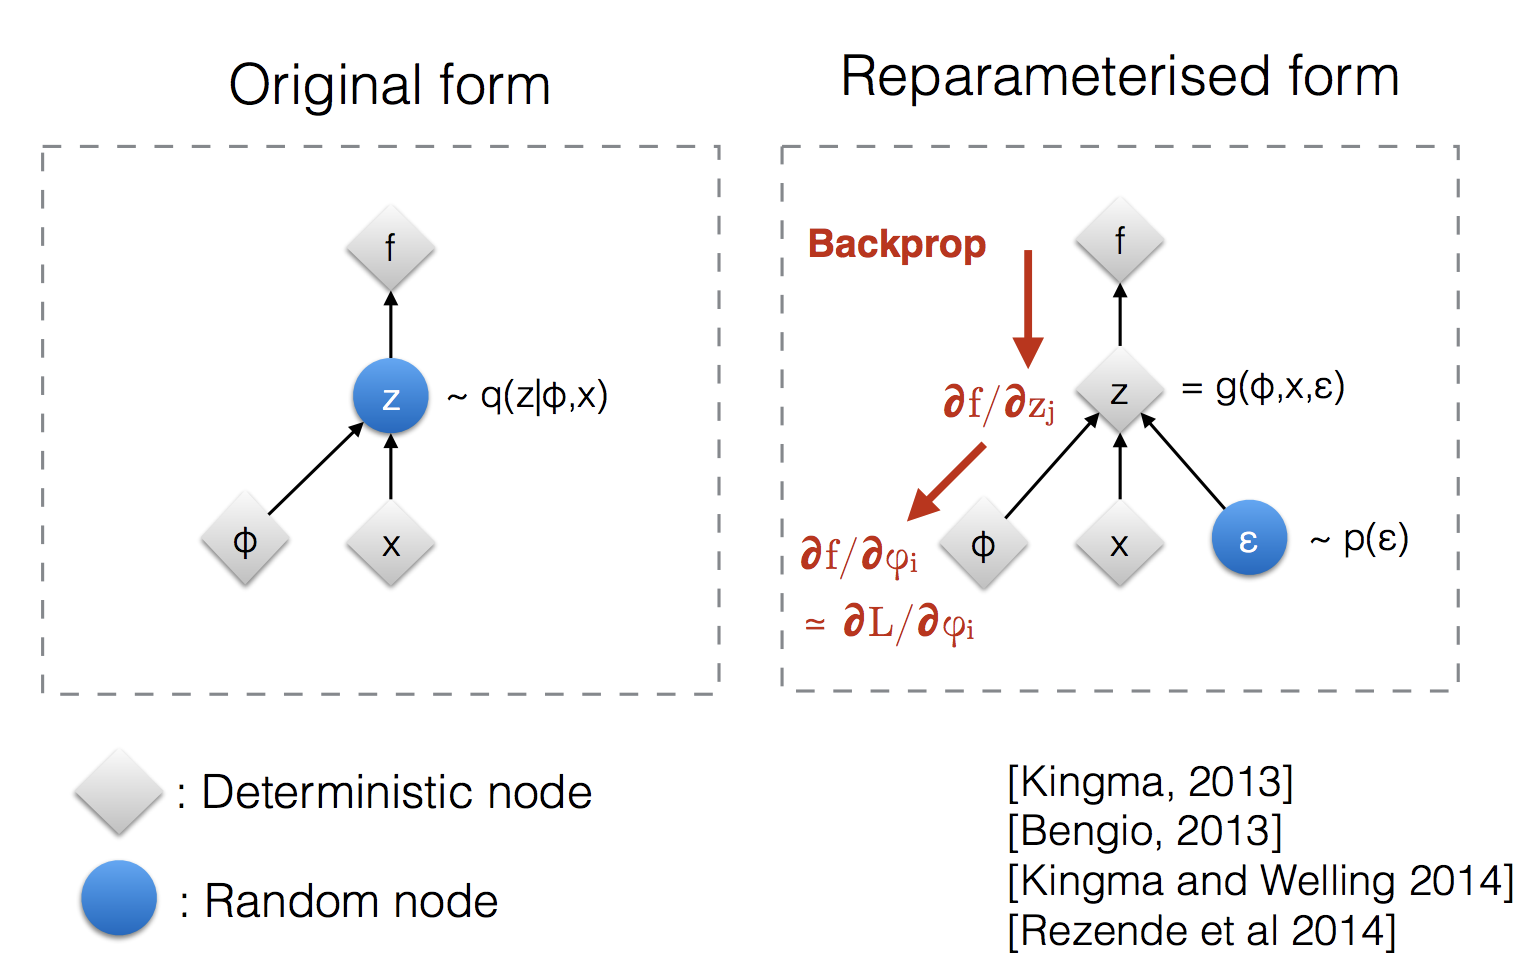
[Kingma, 2015]

For KL divergence loss,
the distribution of latent space is parameterized with ϕ, giving $q_ϕ(z|x)$.
$$\nabla_{ϕ} D_{\text{KL}}(q(z|x) \parallel p(z)) = \nabla_{ϕ} \left[ \int_{z} p_{ϕ}(z) f_{ϕ}(z) \, dz \right]
$$

We will not be able to compute the gradient of the integral in aspect of ϕ.
Thus, we use reparameterize trick to express $z$ as $z = μ(x) + σ(x) ⊙ ϵ$ where $ϵ$ follows (is a random sample of) $N(0,I)$ and ⊙ is element-wise multiplication in our implementation.

Rewritten integral with reparameterization
$$
\nabla_{\phi} \int_{\epsilon} p(\epsilon) f_{\phi}(\mu_{\phi}(x) + \sigma_{\phi}(x) \odot \epsilon) \, d\epsilon
$$

Now, as $ϵ$ is unrelated with $ϕ$, we can moving the gradient inside the integral
$$
\int_{\epsilon} p(\epsilon) \nabla_{\phi} f_{\phi}(\mu_{\phi}(x) + \sigma_{\phi}(x) \odot \epsilon) \, d\epsilon
$$
This derives to the formula we found in the section above.

In [10]:
from logging import log
class SimpleVAE(nn.Module):
  def __init__(self, in_channels=1, out_channels=1, latent_channels=16):
    super().__init__()
    self.encoder = Encoder(in_channels=in_channels, out_channels=out_channels, latent_channels=latent_channels)
    self.decoder = Decoder(in_channels=in_channels, out_channels=out_channels, latent_channels=latent_channels)

  def reparameterize(self, mu, logvar):
    """
    Reparameterize the latent representation to enable gradient computation

    Parameters:
    mu: The mean of from the VAE encoder
    x: The original input.
    mu: The mean from the VAE encoder.
    logvar: The log variance from the VAE encoder.

    Returns:
    The reparameterized latent representation
    """
    ##############################################################################
    # TODO: Implement the reparameterization trick, returning the resultant
    # latent representation
    ##############################################################################
    # Replace "pass" statement with your code (5 pts)
    exp = torch.exp(0.5 * logvar).to('cuda:0')
    epsilon = torch.randn(logvar.size()).to('cuda:0')
    reparam = mu + epsilon * exp
    return reparam
    # END OF YOUR CODE


  def encode(self, x):
    """
    Parameters:
    x: The original input.

    Returns:
    The reparameterized latent representation, mean, and log variance of the
    input distribution from the encoder.
    """
    ##############################################################################
    # TODO: Get the mean and log variance from the encoder
    ##############################################################################
    # Replace "pass" statement with your code (5 pts)
    enc_out = self.encoder(x)
    middle = enc_out.size(1) // 2
    mu = enc_out[:, :middle, :]
    logvar = enc_out[:, middle:, :]
    # END OF YOUR CODE

    z = self.reparameterize(mu, logvar)
    return z, mu, logvar

  def decode(self, z):
    return self.decoder(z)

  def forward(self, x):
    z, mu, logvar = self.encode(x)
    return self.decode(z), mu, logvar

## Training the Simple VAE
# Training the VAE

You can view the weights, samples, and reconstruction images in the files section of Colab.

Your reconstruction should look something like this:
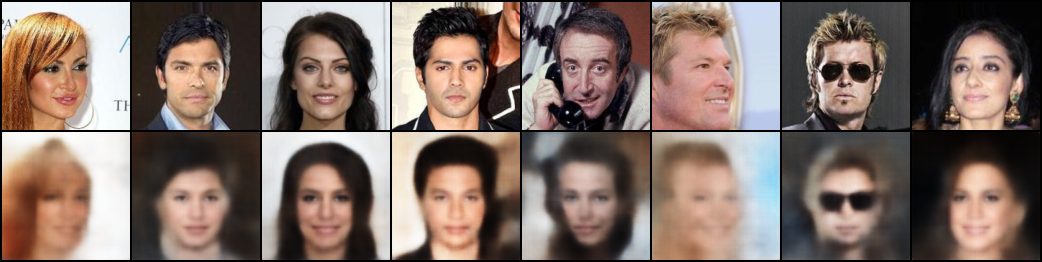

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 32, 2, 64]             896
       BatchNorm2d-2            [-1, 32, 2, 64]              64
              ReLU-3            [-1, 32, 2, 64]               0
         ConvBlock-4            [-1, 32, 2, 64]               0
            Conv2d-5            [-1, 64, 1, 32]          18,496
       BatchNorm2d-6            [-1, 64, 1, 32]             128
              ReLU-7            [-1, 64, 1, 32]               0
         ConvBlock-8            [-1, 64, 1, 32]               0
            Conv2d-9           [-1, 128, 1, 16]          73,856
      BatchNorm2d-10           [-1, 128, 1, 16]             256
             ReLU-11           [-1, 128, 1, 16]               0
        ConvBlock-12           [-1, 128, 1, 16]               0
           Conv2d-13            [-1, 256, 1, 8]         295,168
      BatchNorm2d-14            [-1, 25

Text(0.5, 1.0, 'Loss Curve of SimpleVAE')

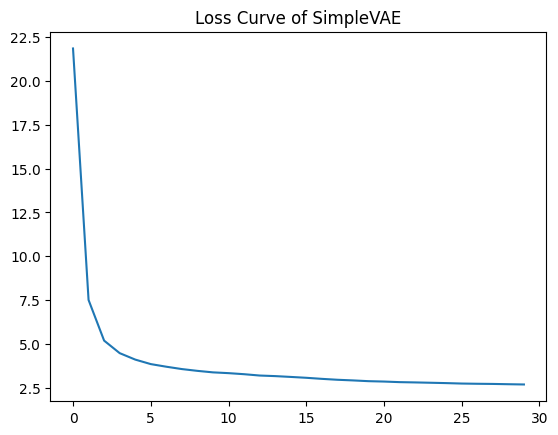

In [12]:
def train_vae(net, lr, epochs, device):

  # for model and results
  # Get the current date and time
  current_datetime = datetime.datetime.now()
  datetime_string = current_datetime.strftime("%Y-%m-%d-%H:%M:%S")

  directory = f'vaemodels-{datetime_string}'
  os.makedirs(directory)
  print(directory)

  optimizer = torch.optim.Adam(net.parameters(), lr=lr)
  loss_list = []
  for epoch in range(epochs):
    net.train()
    train_loss = 0
    train_recon_loss = 0
    train_kld_loss = 0
    train_l2_loss = 0
    for batch_idx, batch in enumerate(train_dataloader):
      if isinstance(batch, list):
          x = batch[0].to(device)
      else:
          x = batch.to(device)
      optimizer.zero_grad()
      recon_batch, mu, logvar = net(x)
      enc_output_shape = mu.shape[2]
      loss, recon_loss, kld_loss, weighted_kld_loss = vae_loss(
          recon_batch, x, mu, logvar, kld_weight=kld_weight
      )
      loss.backward()
      optimizer.step()

      # Accumulate losses (already properly normalized)
      train_loss += loss.item()
      train_recon_loss += recon_loss.item()
      train_kld_loss += kld_loss.item()

      if batch_idx % 100 == 0 and batch_idx > 0:
        # Print normalized, unweighted losses (for training only, no validation)
        print(f'Epoch {epoch+1}, Batch {batch_idx}, Train Loss: {train_loss:.4f} '
              f'(Recon: {train_recon_loss:.4f}, '
              f'KLD: {train_kld_loss:.4f}) ')
    loss_list.append(train_loss)

    # visualize and validate
    torch.save(net, f'{directory}/vae_model_{epoch}.pth')
    test(epoch, directory)

  print("Training completed!")
  return loss_list

def test(epoch, directory):
    """
    Test model performance on validation set and visualize the reconstruction of
    eight validation set samples and visualize a batch size of purely random
    latent tensors.

    Parameters:
    mu: The mean of from the VAE encoder
    x: The original input.
    mu: The mean from the VAE encoder.
    logvar: The log variance from the VAE encoder.

    Returns:
    The reparameterized latent representation
    """

    net.eval()
    test_loss = 0
    with torch.no_grad():
      for i, batch in enumerate(val_dataloader):
        if isinstance(batch, list):
            data = batch[0].to(device)
        else:
            data = batch.to(device)
        ##############################################################################
        # TODO: Implement the validation test loss
        ##############################################################################
        # Replace "pass" statement with your code (5 pts)
        recon_batch, mu, logvar = net(data)
        enc_output_shape = mu.shape[2]
        loss, recon_loss, kld_loss, weighted_kld_loss = vae_loss(
            recon_batch, data, mu, logvar, kld_weight=kld_weight)

        test_loss += loss.item()
        # END OF YOUR CODE

        if i == 0:
            n = min(data.size(0), 8)
            comparison = torch.cat([data[:n],
                                    recon_batch.view(batch_size, 3, 128, 128)[:n]])
            save_image(comparison.cpu(),
                        f'{directory}/reconstruction_{str(epoch)}.png', nrow=n)
            #print(f'Saved to: {directory}/reconstruction_{str(epoch)}.png')


        ##############################################################################
        # TODO: Implement the random sampling visualization. Sample batch_size =
        # 64 random samples and pass them through the VAE.
        #############################################################################
        # Replace "pass" statement with your code (5 pts)
        random = torch.randn(batch_size, latent_channels, enc_output_shape, enc_output_shape).to(device)

        with torch.no_grad():
          sample = net.decode(random)
        # END OF YOUR CODE

        # Replace 'sample' with your variable name if necessary
        save_image(sample.view(batch_size, 3, 128, 128),
                    f'{directory}/sample_{str(epoch)}.png')
        #print(f'Saved to: {directory}/sample_{str(epoch)}.png')

    print('Test set loss: {:.4f}'.format(test_loss))


# hyper-params: feel free to modify the values and numbers of hyper-params
from torchsummary import summary
latent_channels = 128
kld_weight = 0.001
epochs = 30
lr = None
##############################################################################
# TODO: Find a good learning rate to train this model. Make sure your best
# model is saved to the `transformer_net` variable. Feel free to tune other hyperparameters
# as well.
##############################################################################
# Replace "pass" statement with your code (2 pts)
lr = 1e-4
# END OF YOUR CODE

device = torch.device('cuda:0')
net = SimpleVAE(in_channels=3,out_channels=3,latent_channels=latent_channels).to(device)

x = torch.randn(batch_size, 3, 128, 128).to(device)
enc_output_shape = net(x)[2].shape[2]         # For convenient use later

# Print breakdown of architecture
summary(net, input_size=(3, 3, latent_channels))

loss_list = train_vae(net, lr, epochs, device)

plt.plot(np.arange(len(loss_list)), loss_list)
plt.title('Loss Curve of SimpleVAE')




### Display your reconstruction & random sample visualizations for submission

Your random samples should have a (single) human looking face

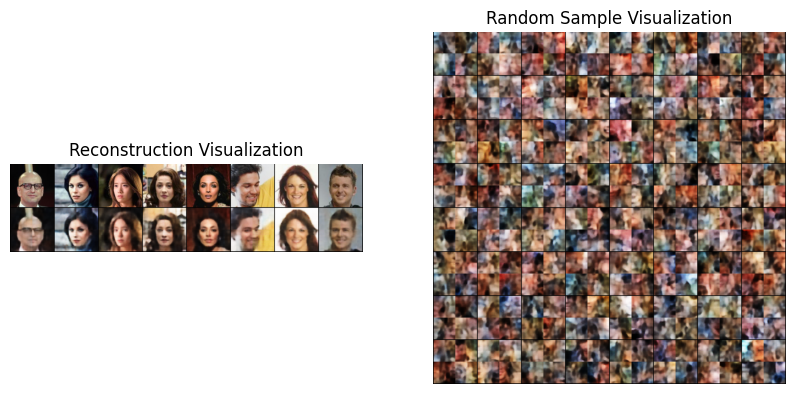

In [24]:
import matplotlib.image as mpimg
recon_filepath = ''
random_sample_filepath = ''
##############################################################################
# TODO: Set recon_filepath and random_sample_filepath to your images for display
##############################################################################
# Replace "pass" statement with your code (2 pts)
recon_filepath = "/content/vaemodels-2024-11-19-21:24:40/reconstruction_29.png" #having to replace each time, could be better but I have 101 fever and am tweaking
random_sample_filepath = "/content/vaemodels-2024-11-19-21:24:40/sample_29.png" #maybe just directory?
# END OF YOUR CODE

fig, axes = plt.subplots(1, 2, figsize=(10, 6))
axes[0].imshow(mpimg.imread(recon_filepath))
axes[0].set_title("Reconstruction Visualization")
axes[0].axis("off")

axes[1].imshow(mpimg.imread(random_sample_filepath))
axes[1].set_title("Random Sample Visualization")
axes[1].axis("off")

plt.show()

# Evaluating our Generated Images

Here are a few commonly used metrics to evaluate image generation quality

## Frechet Inception Distance (FID)
This metric assesses the similarity between generated images and real images. It calculates the Fréchet distance between two multivariate Gaussian distributions, which represent the features of generated images and real images as extracted by a pre-trained Inception network. Lower FID scores indicate better performance, as they imply that the generated images are closer in distribution to the real images.

Mathematically, FID is defined as:
$$
   \text{FID} = \|\mu_r - \mu_g\|^2 + \text{Tr}(\Sigma_r + \Sigma_g - 2(\Sigma_r \Sigma_g)^{1/2}),
$$
are the covariance matrices of the real and generated image feature distributions, respectively.

Original Paper: https://arxiv.org/pdf/1706.08500

*We use the [Torchmetrics package's implementation](https://lightning.ai/docs/torchmetrics/stable/image/frechet_inception_distance.html)*
* Relies on InceptionV3 model to estimate  the multivariate normal distribution for the real images $\textit{N}(\mu_r, \Sigma_g)$ and fake images $\textit{N}(\mu_g, \Sigma_g)$

## Peak Signal to Noise (PSNR)
PSNR is used to quantify the loss of image quality in the reconstruction process based on pixel value difference. Higher PSNR values typically indicate better reconstruction quality.

PSNR is computed as:
$$
\text{PSNR} = 10 \cdot \log_{10} \left(\frac{\text{MAX}^2}{\text{MSE}}\right),
$$
where $\text{MAX}$ represents the maximum possible pixel value (e.g., 255 for an 8-bit image), and $\text{MSE}$ is the mean squared error between the original and reconstructed image.
These metrics provide insights into the generative and reconstructive capabilities of VAEs.

*You should get a PSNR score > 17 and a FID score < 2.5*

In [14]:
!pip install torchmetrics[image]

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 926.4/926.4 kB 33.6 MB/s eta 0:00:00


In [15]:
from torchmetrics.image.fid import FrechetInceptionDistance
from torchmetrics.image import PeakSignalNoiseRatio
from IPython.display import Image as Img, display

In [16]:
def check_fid(net, target):
  metric = FrechetInceptionDistance(feature=2048).to(device)
  samples, mu, logvar = net(target)
  samples = samples.to(dtype=torch.uint8)
  target = target.to(dtype=torch.uint8)
  metric.update(samples, False)
  metric.update(target, True)
  return metric.compute()


In [17]:
def check_psnr(net, target):
  psnr = PeakSignalNoiseRatio().to(device)
  samples = net(target)[0]
  return psnr(samples, target)

In [18]:
def visualize_samples(target, preds):
  if target[0].size(dim=0) != preds[0].size(dim=0):
    print("Number of samples mismatch, will truncate to target number of samples")

  n = len(target)

  comparison = torch.cat([target[:n],
                          preds[:n]])
  save_image(comparison.cpu(),
              f'./compare.png', nrow=n)
  display(Img(filename='./compare.png'))

In [19]:
def checkMetrics(net, num_checks):
  dataset_size = len(val_dataset)
  indices = list(range(dataset_size))
  random_indices = random.sample(indices, num_checks)

  # Create a sampler and dataloader
  sampler = SubsetRandomSampler(random_indices)
  random_loader = DataLoader(val_dataset, sampler=sampler, batch_size=num_checks, pin_memory=True)
  fid = 0
  psnr = 0
  for i, batch in enumerate(random_loader):
    if isinstance(batch, list):
        data = batch[0].to(device)
    else:
        data = batch.to(device)
    data = data[:num_checks]
    fid += check_fid(net, data)
    psnr += check_psnr(net, data)
    visualize_samples(data, net(data)[0])
  return fid, psnr


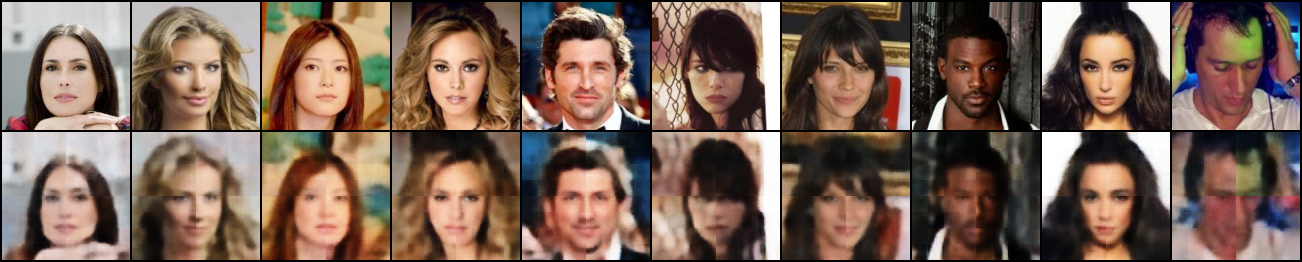

Frechet Inception Distance: 1.5418
Peak Signal to Noise Ratio: 22.7220


In [34]:
model_path = ''
##############################################################################
# TODO: Set model_path to your best model's .pth file to check the metrics
##############################################################################
# Replace "pass" statement with your code (2 pts)
model_path = "/content/vaemodels-2024-11-19-21:24:40/vae_model_29.pth"
# END OF YOUR CODE
net = (torch.load(model_path, weights_only=False)).to(device)
fid, psnr = checkMetrics(net=net, num_checks=10)
print('Frechet Inception Distance: {:.4f}'.format(fid))
print('Peak Signal to Noise Ratio: {:.4f}'.format(psnr))

# Visualizing the Latent Space

Similar to Slide 38 in Lecture 24, let's visualize the latent space by generating samples between the latent representations of two real pictures.

[Lecture 24 Slide 38]
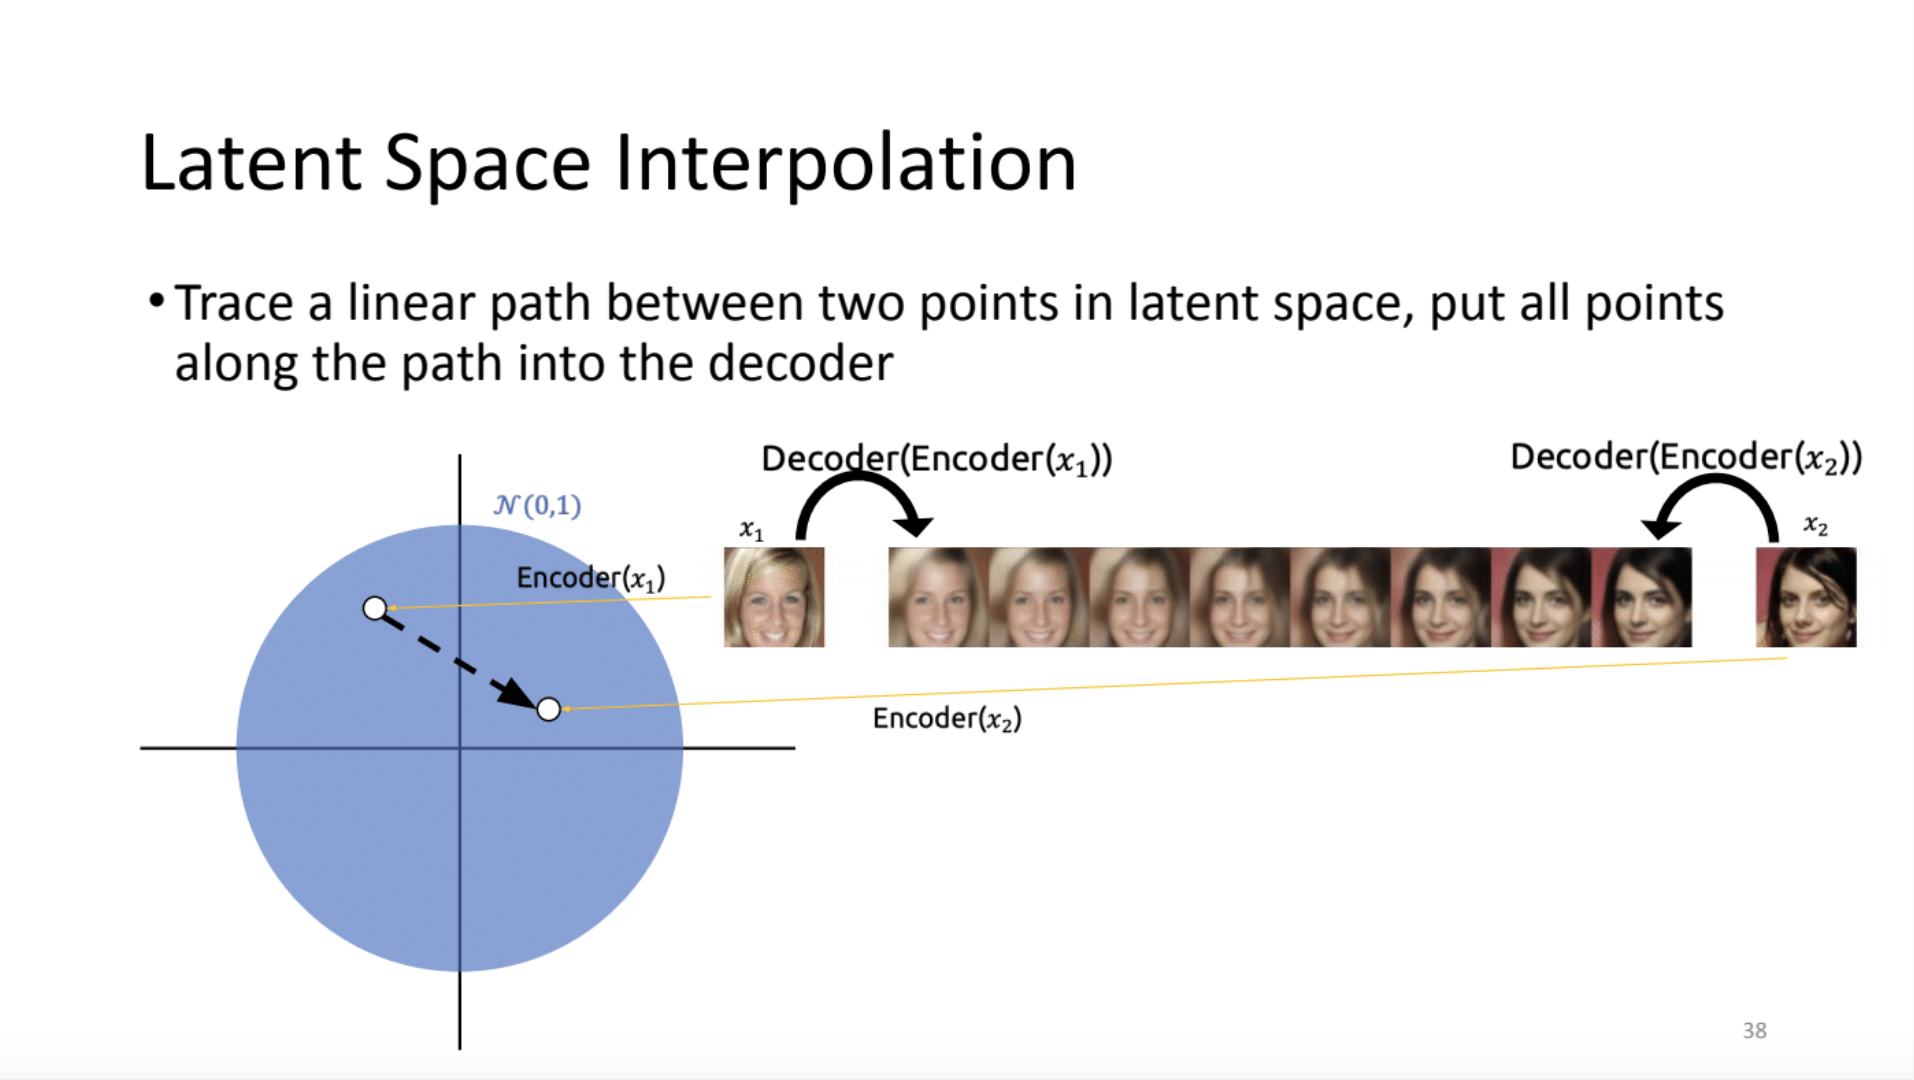



Your output should look similar to the following:
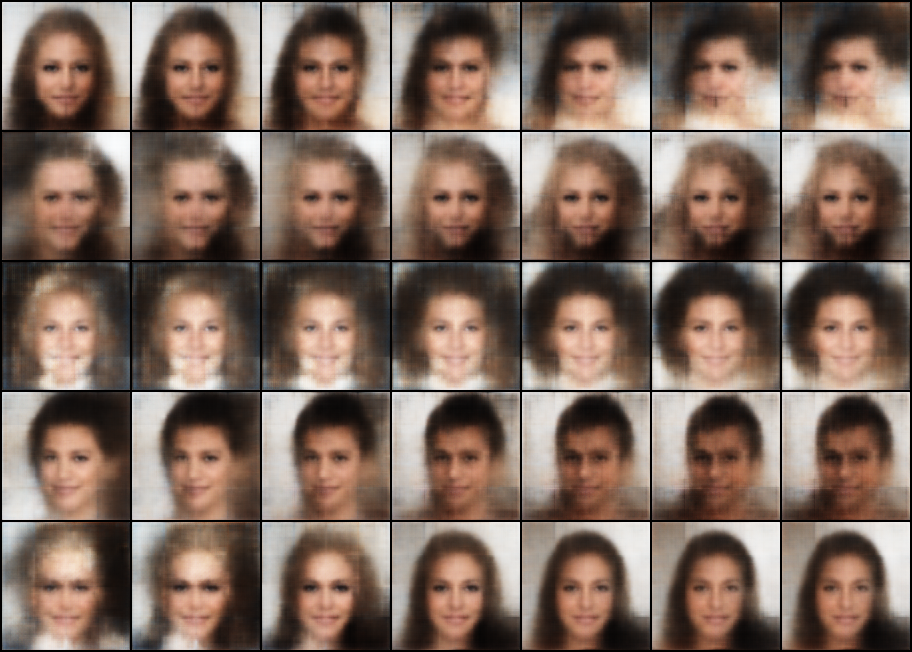

In [32]:
def two_sample_viz(net, num_steps, device, num_tests=5):
  """
  Get two real samples and visualizes num_steps of samples between the latent
  representation of the samples.

  Parameters:
  num_steps: Number of samples to generate between the two real images
  device: current device being used
  num_tests: number of two-sample visualizations to generate

  Returns:
  Filepath where the visualization is saved
  """
  # Folder to save visualization to
  current_datetime = datetime.datetime.now()
  datetime_string = current_datetime.strftime("%Y-%m-%d-%H:%M:%S")

  directory = f'two_sample_viz-{datetime_string}'
  os.makedirs(directory)
  with torch.no_grad():
        latent_imgs = []
        for i, batch in enumerate(val_dataloader):
          if i >= num_tests:
            break
          if isinstance(batch, list):
              random_samples = batch[0].to(device)
          else:
              random_samples = batch.to(device)
          ##############################################################################
          # TODO: Get the latent representation of two samples from the batch and
          # generate the images from evenly spaced latent representations between
          # the samples in the latent space.
          # Append each generated image (including reconstruction of two original)
          # to the latent_imgs list.
          ##############################################################################
          # Replace "pass" statement with your code (2 pts)
          s1 = random_samples[0]
          s2 = random_samples[1]

          l1 = net.encode(s1.unsqueeze(0))[0]
          l2 = net.encode(s2.unsqueeze(0))[0]

          latents = torch.linspace(0, 1, steps=num_steps+2, device=device).view(-1, 1, 1, 1) * l1 + \
                                  (1 - torch.linspace(0, 1, steps=num_steps+2, device=device).view(-1, 1, 1, 1)) * l2

          images = net.decode(latents)

          latent_imgs.extend(images)

          # END OF YOUR CODE

        comparison = torch.stack(latent_imgs)
        filepath = f'{directory}/latent_vis.png'
        save_image(comparison.cpu(),
                    filepath, nrow=num_steps+2)
  return filepath
net = SimpleVAE(in_channels=3, out_channels=3, latent_channels=latent_channels)
model_path = model_path
##############################################################################
# TODO: Set model_path to your best model's .pth file to check the metrics
##############################################################################
# Replace "pass" statement with your code (2 pts)
model_path = "/content/vaemodels-2024-11-19-21:24:40/vae_model_29.pth" #already saved above but whatever
# END OF YOUR CODE
net = (torch.load(model_path, weights_only=False)).to(device)

# Get enc_output_shape again
x = torch.randn(64, 3, 128, 128).to(device)
enc_output_shape = net(x)[2].shape[2]

fp = two_sample_viz(net, 5, device)

### Display Visualization Image for submission

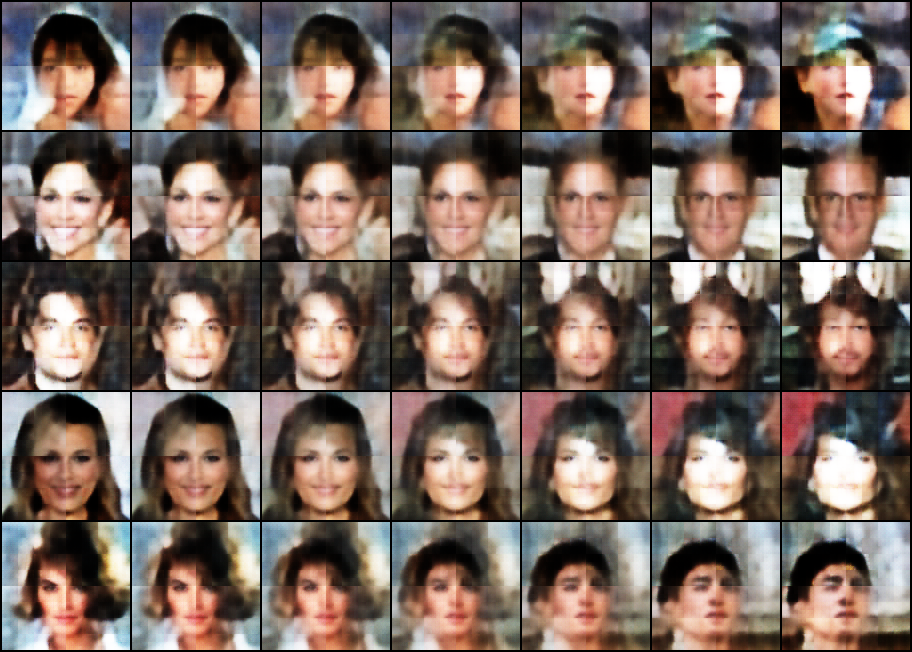

In [33]:
from IPython.display import Image as Img

Img(filename=fp)